# PRISMO vs MOFA on CLL Data

## PRISMO

In [1]:
# # run with "prismo" kernel
# from prismo import (
#     PRISMO,
#     DataOptions,
#     ModelOptions,
#     TrainingOptions,
# )
# from data_loader import load_cll

# data = load_cll()

# for seed in range(10):
#     prismo_model = PRISMO(
#         data,
#         DataOptions(
#             plot_data_overview=False,
#         ),
#         ModelOptions(
#             n_factors=10,
#             weight_prior="SnS",
#             factor_prior="Normal",
#             likelihoods="Normal",
#         ),
#         TrainingOptions(
#             device="cuda:0",
#             max_epochs=10000,
#             lr=0.05,
#             early_stopper_patience=1000,
#             print_every=500,
#             save_path=f"models/prismo_{seed}",
#             seed=seed,
#         )
#     )

## MOFA

In [2]:
# # run with "muon" kernel
# import muon as mu
# import pandas as pd
# from data_loader import load_cll

# data = load_cll()
# mdata = mu.MuData(data)
# obs = pd.read_csv("data/cll_metadata.csv", index_col="Sample")
# mdata.obs = mdata.obs.join(obs)

# mu.tl.mofa(mdata, use_obs='union',
#     n_factors=10, convergence_mode='medium',
#     outfile="models/mofa.h5"
#     )

## Comparison

In [268]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
from prismo import PRISMO
from prismo.tl import match
from plotnine import *
from data_loader import load_cll

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
mofa_model = mofa.mofa_model("models/mofa.h5")
z_mofa = pd.DataFrame(
    mofa_model.factors['group1'][:].T,
    index=mofa_model.samples['group1'],
    columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)],
)

w_mofa = {}
for view in mofa_model.views:
    w_mofa[view] = pd.DataFrame(
        mofa_model.weights[view][:].T,
        index=mofa_model.features[view],
        columns=[f"Factor {i+1}" for i in range(mofa_model.nfactors)]
    )
r2_mofa = mofa_model.get_variance_explained().drop(columns="Group")

z_prismo = {}
w_prismo = {}
r2_prismo = {}
prismo_model = {}
for seed in range(10):
    prismo_model[seed] = PRISMO.load(f"models/prismo_{seed}.h5")
    z_prismo[seed] = prismo_model[seed].get_factors()['group_1']
    w_prismo[seed] = {}
    for view in prismo_model[seed].view_names:
        w_prismo[seed][view] = prismo_model[seed].get_weights()[view].T
    r2_prismo[seed] = prismo_model[seed].get_r2()['group_1'].reset_index(names="Factor").melt(id_vars="Factor", var_name="View", value_name="R2")

### Factor matching based on correlation

In [165]:
for seed in range(10):
    z_mofa_inds, z_prismo_inds, z_signs = match(z_mofa, z_prismo[seed], dim=-1)

    z_prismo[seed] = z_prismo[seed].iloc[:, z_prismo_inds]
    z_prismo[seed] = z_prismo[seed] * z_signs.reshape(1, -1)
    z_prismo[seed].columns = [f"Factor {i+1}" for i in range(z_prismo[seed].shape[1])]

    for view in w_prismo[seed].keys():
        w_prismo[seed][view] = w_prismo[seed][view].iloc[:, z_prismo_inds]
        w_prismo[seed][view] = w_prismo[seed][view] * z_signs.reshape(1, -1)
        w_prismo[seed][view].columns = [f"Factor {i+1}" for i in range(w_prismo[seed][view].shape[1])]

    r2_prismo[seed] = prismo_model[seed].get_r2()['group_1']
    r2_prismo[seed] = prismo_model[seed].get_r2()['group_1'].iloc[z_prismo_inds]
    r2_prismo[seed].index = [f"Factor {i+1}" for i in range(prismo_model[seed].n_factors)]
    r2_prismo[seed] = r2_prismo[seed].reset_index(names="Factor").melt(id_vars="Factor", var_name="View", value_name="R2")

w_prismo_mean = {}
for view in w_prismo[0].keys():
    w_prismo_mean[view] = pd.concat([w_prismo[seed][view] for seed in range(10)], axis=0).groupby(level=0).mean()

r2_prismo_mean = pd.concat([r2_prismo[seed] for seed in range(10)], axis=0).groupby(["Factor", "View"]).mean().reset_index()
r2_prismo_mean.replace({f"Factor {i}" : f"{i}" for i in range(1, 11)}, inplace=True)
r2_mofa.replace({f"Factor{i}" : f"{i}" for i in range(1, 11)}, inplace=True)

r2_prismo_mean["Factor"] = pd.Categorical(r2_prismo_mean["Factor"], categories=[f"{i}" for i in range(1, 11)], ordered=True)
r2_mofa["Factor"] = pd.Categorical(r2_mofa["Factor"], categories=[f"{i}" for i in range(1, 11)], ordered=True)
r2_mofa["R2"] = r2_mofa["R2"] / 100

### Correlation plots

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 2 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/correlations.pdf
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


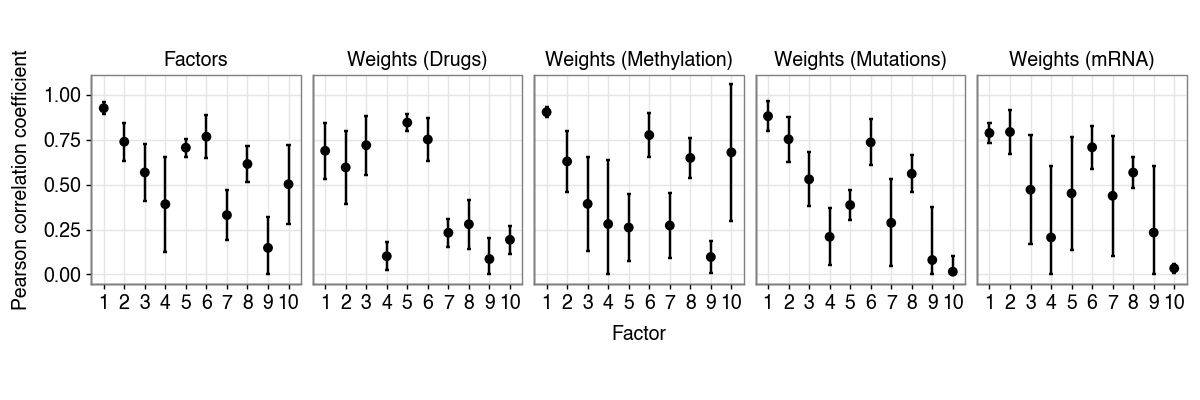

In [273]:
df = []
for seed in range(10):
    corr = []
    for i in range(z_prismo[seed].shape[1]):
        corr.append(pearsonr(z_prismo[seed].iloc[:, i], z_mofa.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(z_prismo[seed].shape[1])]
    df[-1]["lv"] = "Factors"

    for view in w_prismo[seed].keys():
        corr = []
        for i in range(w_prismo[seed][view].shape[1]):
            corr.append(pearsonr(w_prismo[seed][view].iloc[:, i], w_mofa[view].iloc[:, i])[0])
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(w_prismo[seed][view].shape[1])]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(10)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0, a_max=10)
df["max"] = np.clip(df["max"], a_min=0, a_max=10)

df.replace({
    "Weights (mrna)" : "Weights (mRNA)",
    "Weights (methylation)" : "Weights (Methylation)",
    "Weights (drugs)" : "Weights (Drugs)",
    "Weights (mutations)" : "Weights (Mutations)",
}, inplace=True)

plot = (
    ggplot(df, aes(x="factor", y="mean"))
    + geom_point(size=1.)
    + geom_line()
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=5)
    + theme(
        figure_size=(6, 2),
    )
    + labs(x="Factor", y="Pearson correlation coefficient")
)
plot.save("plots/correlations.pdf")
plot.show()

### Weights scatter plots

In [210]:
def plot_weights(view, factor, w_prismo_mean, w_mofa):
    df = pd.DataFrame(w_prismo_mean[view][factor])
    df.columns = ["weight_prismo"]
    df["weight_mofa"] = w_mofa[view][factor]
    df["weight_prismo_abs"] = df["weight_prismo"].abs()
    df["weight_mofa_abs"] = df["weight_mofa"].abs()

    if view == "mrna":
        view_plot = "mRNA"
    elif view == "methylation":
        view_plot = "Methylation"
    elif view == "drugs":
        view_plot = "Drugs"
    elif view == "mutations":
        view_plot = "Mutations"


    plot = (
        ggplot(df, aes(x="weight_prismo", y="weight_mofa"))
        + geom_point(size=1.)
        + labs(x="PRISMO weight", y="MOFA weight", title=f"{factor} ({view_plot})")
        + theme(figure_size=(1.5, 1.5))
        + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
        + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    )
    return plot

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/mutations_factor1_weights.pdf


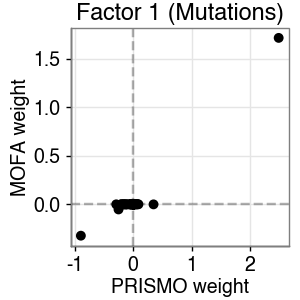

In [211]:
plot = plot_weights("mutations", "Factor 1", w_prismo_mean, w_mofa)
plot.save("plots/mutations_factor1_weights.pdf")
plot.show()

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 1.5 x 1.5 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/mutations_factor2_weights.pdf


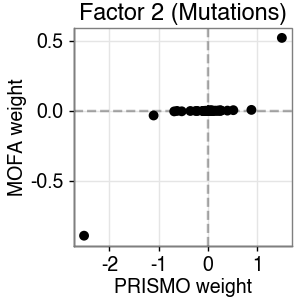

In [212]:
plot = plot_weights("mutations", "Factor 2", w_prismo_mean, w_mofa)
plot.save("plots/mutations_factor2_weights.pdf")
plot.show()

### Variance explained plots

In [261]:
def plot_r2(df, title=None):
    df["factor"] = pd.Categorical(df["Factor"], categories=df["Factor"].unique())
    df["View"].replace({
        "mutations" : "Mutations",
        "mrna" : "mRNA",
        "methylation" : "Methylation",
        "drugs" : "Drugs",
    }, inplace=True)

    df["view"] = pd.Categorical(df["View"], categories=["Mutations", "mRNA", "Methylation", "Drugs"])

    plot = (
        ggplot(df, aes(x="View", y="Factor", fill="R2"))
        + geom_tile()
        + scale_fill_distiller(palette="OrRd", limits=(0, None), expand=(0, 0, 1.1, 0), name="R2")
        + labs(x="View", y="Factor", title=title, fill="R2")
        + theme(axis_text_x=element_text(rotation=90), figure_size=(1.5, 2), legend_key_width=3.)
    )
    return plot

/tmp/ipykernel_788299/1645819490.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




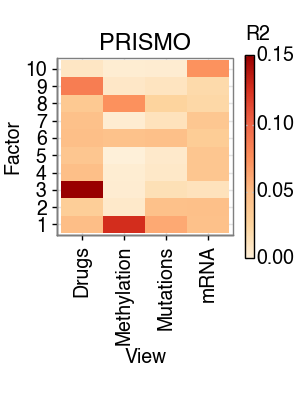

In [262]:
plot = plot_r2(r2_prismo_mean, "PRISMO")
fig = plot.draw()
fig.savefig(f"plots/variance_explained_prismo.pdf")
plot.show()

/tmp/ipykernel_788299/1645819490.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




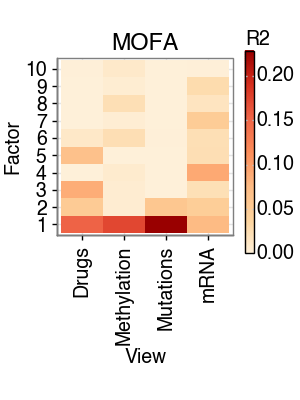

In [263]:
plot = plot_r2(r2_mofa, "MOFA")
fig = plot.draw()
fig.savefig(f"plots/variance_explained_mofa.pdf")
plot.show()

In [317]:
data = load_cll()

metadata = pd.read_csv("data/cll_metadata.csv", index_col="Sample")
metadata = pd.merge(pd.DataFrame(index=prismo_model[0].sample_names["group_1"]), metadata, left_index=True, right_index=True)
metadata["trisomy12"] = data['mutations'].to_df()["m_trisomy12"]
metadata

,Diagnosis,Gender,IGHV,Age4Main,T5,T6,treatedAfter,died,IC50beforeTreatment,ConsClust,trisomy12
H005,CLL,m,M,75.265753,0.574949,2.625599,True,False,False,IP,0.0
H006,CLL,m,M,NaN,NaN,NaN,NaN,NaN,NaN,HP,0.0
H007,CLL,f,U,NaN,NaN,NaN,NaN,NaN,NaN,LP,0.0
H008,CLL,m,U,NaN,NaN,NaN,NaN,NaN,NaN,LP,0.0
H010,CLL,f,U,72.780822,2.932238,2.932238,False,False,True,LP,0.0
...,...,...,...,...,...,...,...,...,...,...,...
H266,CLL,m,M,74.315068,0.002738,0.903491,True,False,False,HP,NaN
H268,CLL,m,NaN,82.539726,0.076660,0.577687,True,False,True,HP,0.0
H270,CLL,f,M,66.947945,0.216290,0.903491,True,False,True,IP,0.0
H271,CLL,m,M,65.380822,0.859685,0.859685,False,False,True,HP,0.0


In [321]:
z_prismo_mean = pd.concat([z_prismo[seed] for seed in range(10)], axis=0).groupby(level=0).mean()

z_prismo_mean

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10
H005,0.265989,0.234144,0.129886,0.248935,-0.250481,-0.133726,-0.138300,-0.537679,0.161167,-0.444439
H006,0.569231,-0.469107,-0.106371,0.059325,0.120784,-0.013903,0.038737,0.315389,-0.002850,-0.024098
H007,-0.500676,0.193388,-0.356831,0.181444,0.074826,-0.055859,0.089976,-0.060095,-0.073156,-0.039033
H008,-0.659004,0.188940,0.027099,-0.121533,0.053952,0.184863,0.139727,-0.250757,-0.050755,0.384203
H010,-0.655571,0.139154,-0.128968,0.300534,-0.305231,0.327809,0.040259,-0.048334,0.166786,-0.584054
...,...,...,...,...,...,...,...,...,...,...
H266,0.592694,0.086122,0.095128,0.135889,0.120269,0.023418,0.246286,0.315446,-0.034952,-0.115650
H268,0.423355,-0.065783,0.015351,0.106297,0.123918,0.252027,0.161110,0.367677,0.043298,-0.020493
H270,0.417120,0.326984,-0.214239,0.149675,0.060006,0.045584,0.182151,-0.361211,-0.007644,0.322744
H271,0.426131,0.084860,0.031085,0.051407,0.163148,0.297267,0.229431,0.390483,0.079571,0.165606


In [343]:
df = metadata[["IGHV", "trisomy12"]].astype("str")
df["prismo_factor_1"] = z_prismo_mean["Factor 1"]
df["prismo_factor_2"] = z_prismo_mean["Factor 2"]
df["mofa_factor_1"] = z_mofa["Factor 1"]
df["mofa_factor_2"] = z_mofa["Factor 2"]
df["trisomy12"] = df["trisomy12"].replace({"0.0" : "No", "1.0" : "Yes"})
df.replace({"nan" : "unknown"}, inplace=True)

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/prismo_factors.pdf


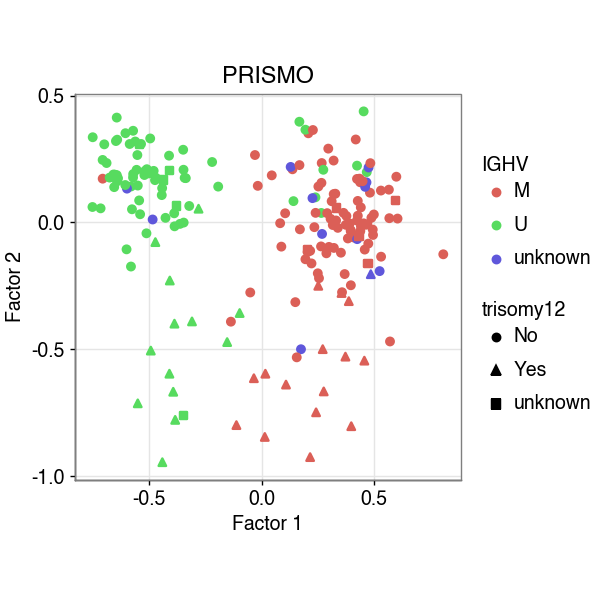

In [352]:
plot = (
    ggplot(df, aes(x="prismo_factor_1", y="prismo_factor_2", color="IGHV", shape="trisomy12"))
    + geom_point(size=1.0)
    + labs(x="Factor 1", y="Factor 2", title="PRISMO")
    + theme(figure_size=(3, 3))
)
plot.save("plots/prismo_factors.pdf")
plot.show()

/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 3 in image.
/data/florin/micromamba/envs/prismo/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/mofa_factors.pdf


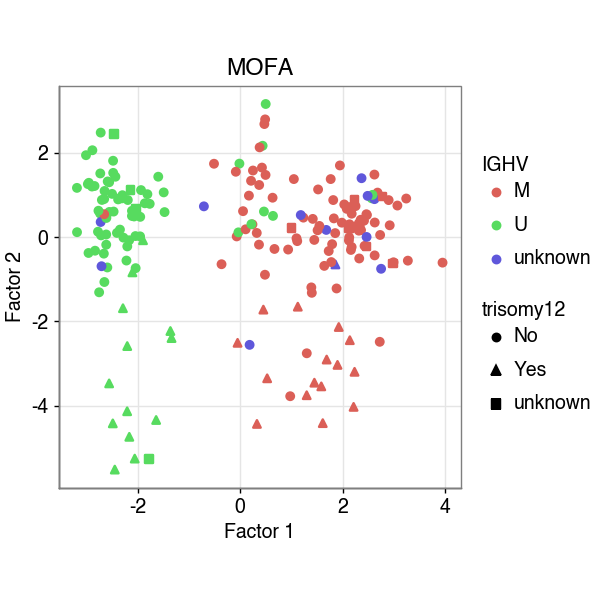

In [351]:
plot = (
    ggplot(df, aes(x="mofa_factor_1", y="mofa_factor_2", color="IGHV", shape="trisomy12"))
    + geom_point(size=1.0)
    + labs(x="Factor 1", y="Factor 2", title="MOFA")
    + theme(figure_size=(3, 3))
)
plot.save("plots/mofa_factors.pdf")
plot.show()